Base repr   : data/representations/resnet18
Base results: data/results/1space/resnet18

=== Dataset: cifar9
Representações: (45000, 512)
Entropia média: 0.34495065  | shape: (45000,)


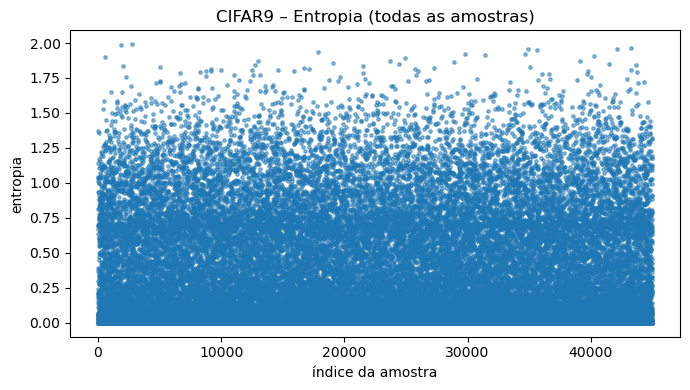


--> Budget k = 0.1


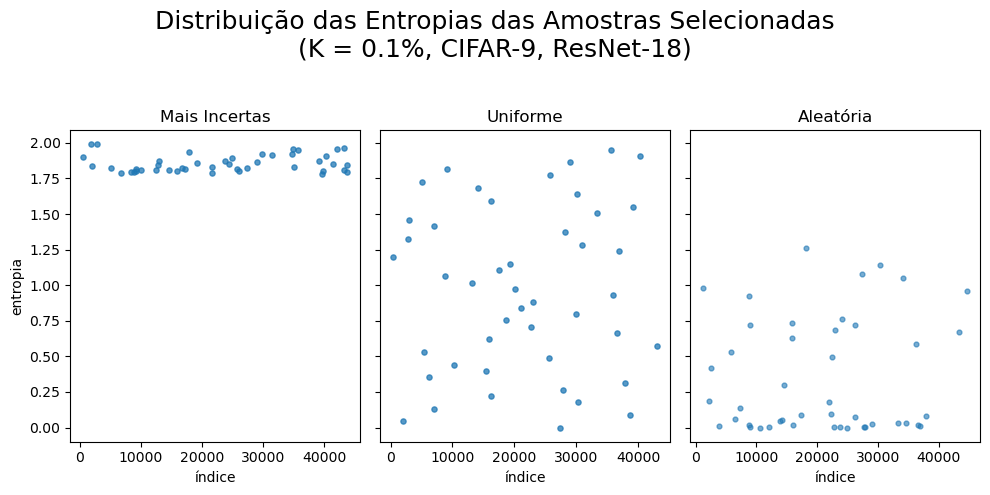


--> Budget k = 1


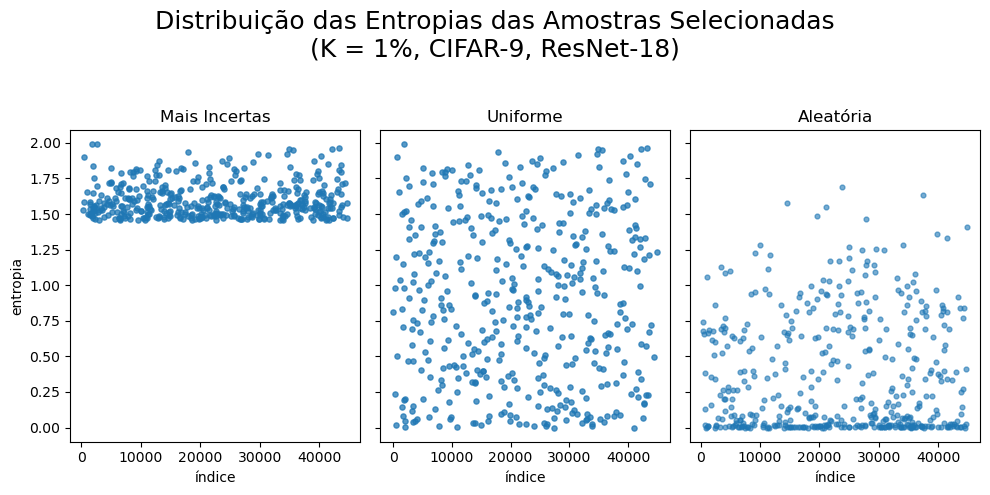


--> Budget k = 10


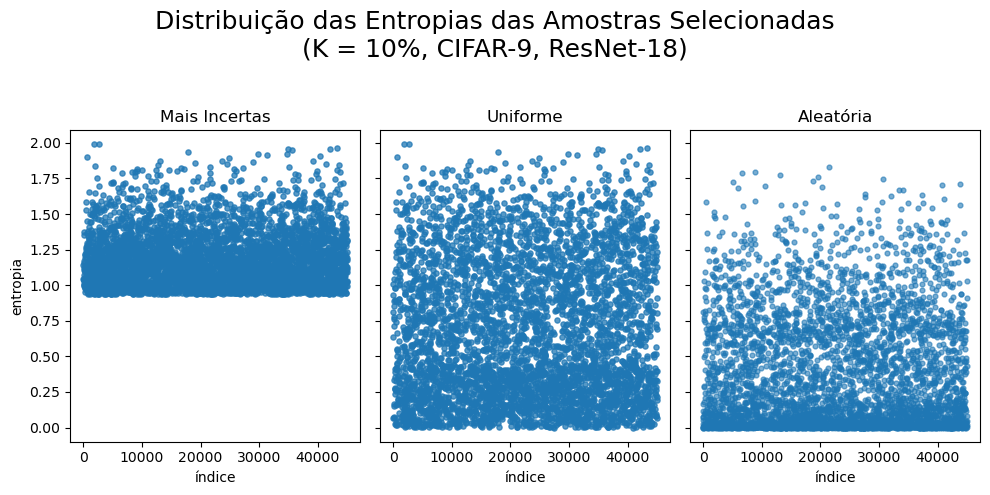


=== Dataset: stl9
Representações: (4500, 512)
Entropia média: 0.060240716  | shape: (4500,)


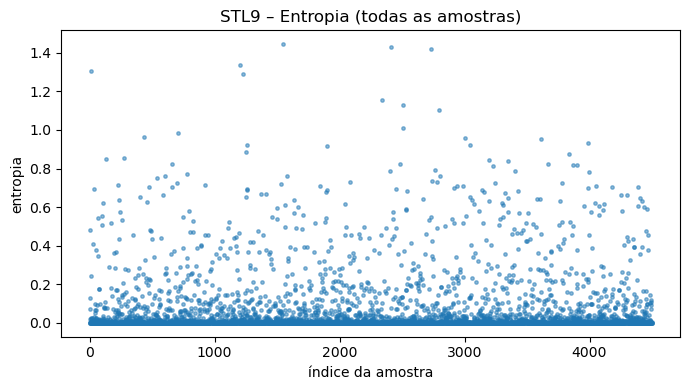


--> Budget k = 0.1


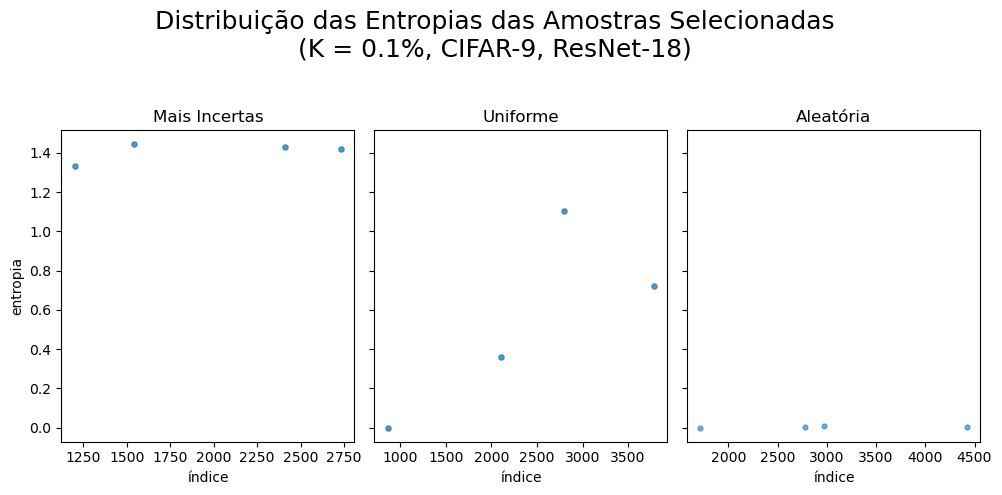


--> Budget k = 1


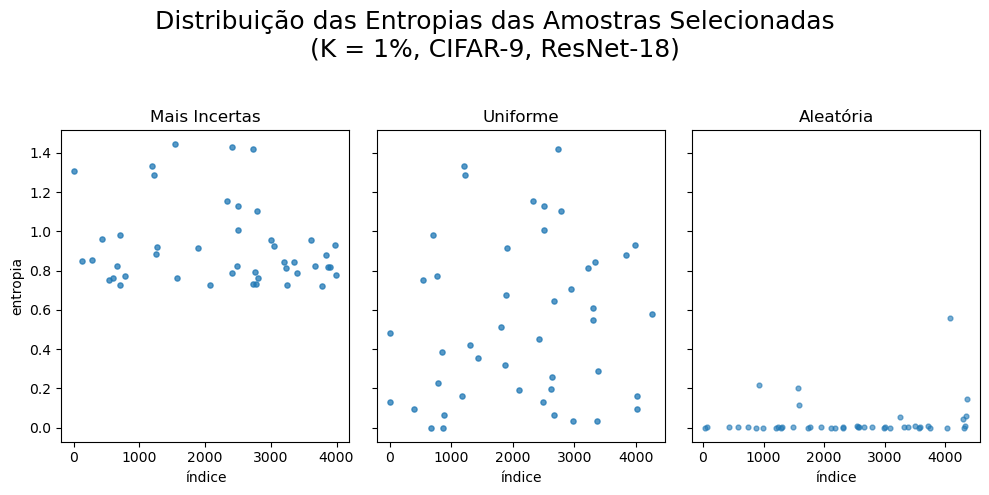


--> Budget k = 10


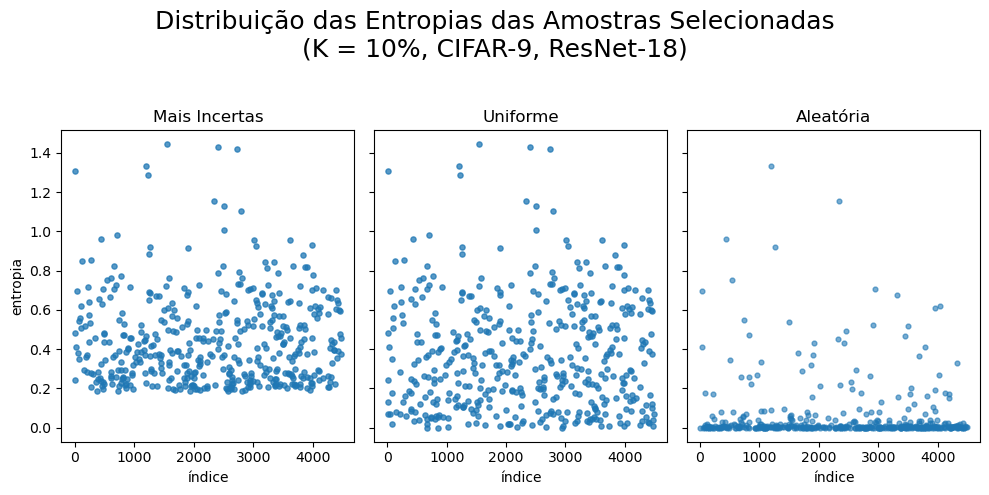

In [55]:
# ==========================================================
# Análise de entropia — CIFAR9 e STL9 (ResNet-18)
# ==========================================================

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

# ==========================================================
# Caminhos base
# ==========================================================
base_repr = Path("data/representations/resnet18")
base_res  = Path("data/results/1space/resnet18")

print("Base repr   :", base_repr)
print("Base results:", base_res)

# ==========================================================
# Configuração dos datasets
# ==========================================================
datasets = {
    "cifar9": {
        "repr_train": base_repr / "cifar9_train.npy",
        "budgets": ["0.1", "1", "10"],
    },
    "stl9": {
        "repr_train": base_repr / "stl9_train.npy",
        "budgets": ["0.1", "1", "10"],
    },
}

# ==========================================================
# Função auxiliar
# ==========================================================
def load_entropy(dataset):
    """
    Carrega entropia média salva como arquivo .pt.
    Retorna tensor PyTorch.
    """
    ent_path = base_res / f"entropy_mean_{dataset}.pt"
    if not ent_path.exists():
        raise FileNotFoundError(f"Arquivo de entropia não encontrado: {ent_path}")
    return torch.load(ent_path)


# ==========================================================
# Loop principal
# ==========================================================
for ds, info in datasets.items():

    print(f"\n==========================================")
    print(f"=== Dataset: {ds}")
    print("==========================================")

    # ------------------------------
    # Carregar representações
    # ------------------------------
    X = np.load(info["repr_train"])
    print("Representações:", X.shape)

    # ------------------------------
    # Carregar entropia
    # ------------------------------
    ent = load_entropy(ds)
    ent_np = ent.detach().cpu().numpy()

    print("Entropia média:", ent_np.mean(), " | shape:", ent_np.shape)

    # --------------------------------------------------------
    # 1) Scatter da ENTROPIA de todas as amostras
    # --------------------------------------------------------
    plt.figure(figsize=(7, 4))
    plt.scatter(np.arange(len(ent_np)), ent_np, s=6, alpha=0.5)
    plt.title(f"{ds.upper()} – Entropia (todas as amostras)")
    plt.xlabel("índice da amostra")
    plt.ylabel("entropia")
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------
    # 2) Análise por budget k
    # --------------------------------------------------------
    for b in info["budgets"]:
        print(f"\n--> Budget k = {b}")

        # Caminho da pasta: data/results/.../Kpct_b/
        dir_k = base_res / f"Kpct_{b}"

        # Carregar índices
        idx_uncertain = torch.load(dir_k / f"uncertain_indexes_{ds}_Kpct_{b}.pt", weights_only=False)
        idx_uniform   = torch.load(dir_k / f"uniform_indexes_{ds}_Kpct_{b}.pt", weights_only=False)
        idx_random    = torch.load(dir_k / f"random_1_indexes_{ds}_Kpct_{b}.pt", weights_only=False)

        # --------------------------------------------------------
        # 3) Gráficos UM EMBAIXO DO OUTRO (3 × 1)
        # --------------------------------------------------------
        fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

        # ---------- UNCERTAINTY ----------
        axes[0].scatter(idx_uncertain, ent_np[idx_uncertain], s=14, alpha=0.75)
        axes[0].set_title("Mais Incertas")
        axes[0].set_xlabel("índice")
        axes[0].set_ylabel("entropia")

        # ---------- UNIFORM ----------
        axes[1].scatter(idx_uniform, ent_np[idx_uniform], s=14, alpha=0.75)
        axes[1].set_title("Uniforme")
        axes[1].set_xlabel("índice")
        # axes[1].set_ylabel("entropia")

        # ---------- RANDOM ----------
        axes[2].scatter(idx_random, ent_np[idx_random], s=12, alpha=0.6)
        axes[2].set_title("Aleatória")
        axes[2].set_xlabel("índice")
        # axes[2].set_ylabel("entropia")

        fig.suptitle(
            f"Distribuição das Entropias das Amostras Selecionadas\n"
            f"(K = {b}%, CIFAR-9, ResNet-18)\n",
            fontsize=18
        )

        plt.tight_layout()
        plt.show()
